In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_boston

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

In [2]:
print(load_boston()['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [3]:
ds = pd.DataFrame(load_boston()['data'], columns=load_boston()['feature_names'])
ds['target'] = load_boston()['target']
print(ds.shape)
ds.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [4]:
ds.isna().sum().sum()

0

In [5]:
X_train, X_test, y_train, y_test = train_test_split(ds.drop('target',1), ds['target'])
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((379, 13), (127, 13), (379,), (127,))

# Базовые версии разных моделей

In [6]:
def evaluate_model(model, model_name, X=X_test, y=y_test):
    res = {'model':model_name,
           'mse': mean_squared_error(y, model.predict(X)),
           'r2': r2_score(y, model.predict(X))}
    return res_ds.append(res, ignore_index=True)

In [7]:
res_ds = pd.DataFrame(columns=['model','mse','r2'])

In [8]:
lr_base = Ridge()
lr_base.fit(X_train,y_train)
res_ds = evaluate_model(lr_base, 'lr_base')

In [9]:
xgb_base = XGBRegressor()
xgb_base.fit(X_train, y_train)
res_ds = evaluate_model(xgb_base, 'xgb_base')

[23:06:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [10]:
rf_base = RandomForestRegressor()
rf_base.fit(X_train, y_train)
res_ds = evaluate_model(rf_base, 'rf_base')

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


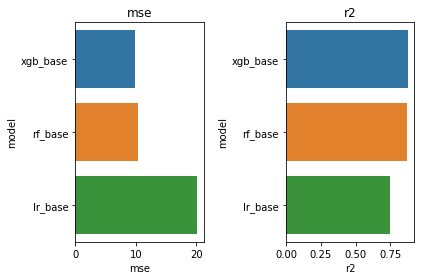

In [11]:
for idx, m in enumerate(['mse','r2']):
    plt.subplot(1, res_ds.shape[1]-1, idx+1)
    sns.barplot(y='model',x=m, data=res_ds.sort_values(m, ascending=False if m=='r2' else True))
    plt.title(m)
plt.tight_layout()
plt.show()

# GridSearch

In [12]:
lr_grid_params = {'alpha': np.linspace(1e-6, 100, 1000),
           'normalize': [False, True]}
lr_grid = RandomizedSearchCV(Ridge(), lr_grid_params,
                             cv=10, scoring='neg_mean_squared_error',
                             n_iter=1000, verbose=1, n_jobs=-1)
lr_grid.fit(X_train, y_train)
print(lr_grid.best_params_)
res_ds = evaluate_model(lr_grid.best_estimator_, 'lr_best')

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 250 tasks      | elapsed:    2.0s


{'normalize': True, 'alpha': 1e-06}


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:   18.1s finished
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [13]:
xgb_grid_params = {'max_depth': sorted(set(np.logspace(0, 3, 10, base=10).astype(int))),
                   'learning_rate': np.linspace(1e-5, 1, 50),
                   'n_estimators': sorted(set(np.logspace(0,3, 10, base=10).astype(int)))}
xgb_grid = RandomizedSearchCV(XGBRegressor(), xgb_grid_params,
                             cv=10, scoring='neg_mean_squared_error',
                             n_iter=1000, verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
print(xgb_grid.best_params_)
res_ds = evaluate_model(xgb_grid.best_estimator_, 'xgb_best')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 1000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Done 212 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 816 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 1717 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 2869 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 4459 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 6403 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 8353 tasks      | elapsed:  4.3min


[23:12:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.16327367346938776}


[Parallel(n_jobs=-1)]: Done 10000 out of 10000 | elapsed:  5.0min finished
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/egor/.local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [14]:
rf_grid_params = {'max_depth': list(set(np.logspace(0, 3, 10, base=10).astype(int))),
                   'n_estimators': list(set(np.logspace(0,3, 10, base=10).astype(int)))}
rf_grid = RandomizedSearchCV(RandomForestRegressor(), rf_grid_params,
                             cv=10, scoring='neg_mean_squared_error',
                             n_iter=1000, verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)
print(rf_grid.best_params_)
res_ds = evaluate_model(rf_grid.best_estimator_, 'rf_best')

/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 100 is smaller than n_iter=1000. Running 100 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Done 281 tasks      | elapsed:   22.8s
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 619 tasks      | elapsed:  1.2min
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout

{'n_estimators': 46, 'max_depth': 100}


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  2.4min finished
/home/egor/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# Итого

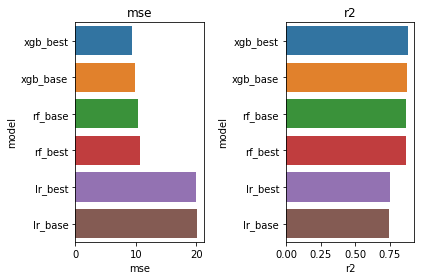

In [15]:
for idx, m in enumerate(['mse','r2']):
    plt.subplot(1, res_ds.shape[1]-1, idx+1)
    sns.barplot(y='model',x=m, data=res_ds.sort_values(m, ascending=False if m=='r2' else True))
    plt.title(m)
plt.tight_layout()
plt.show()

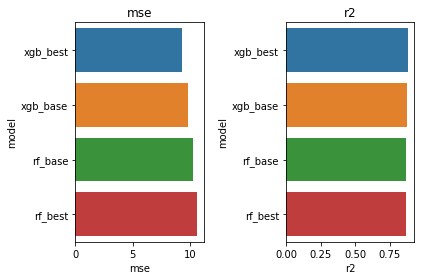

In [16]:
for idx, m in enumerate(['mse','r2']):
    plt.subplot(1, res_ds.shape[1]-1, idx+1)
    sns.barplot(y='model',x=m,
                data=res_ds[-res_ds['model'].isin(['lr_base','lr_best'])].sort_values(m, ascending=False if m=='r2' else True))
    plt.title(m)
plt.tight_layout()
plt.show()

Разница результатов моделей зависит скорее от выбранного алгоритма, чем от подстройки параметров. Последняя даёт лишь незначительный прирост.